# Install nussl et import systématiques

## Install de nussl

In [24]:
# à ne faire qu'une fois pour installer le paquet nussl
!pip install nussl

## Imports

In [13]:
# Chargement des paquets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import librosa
import nussl
import numpy as np
import os,sys
import importlib # pour mise à jour des lib en développement


SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


## Montage du drive et du working directory

Montage du drive

In [3]:
from google.colab import drive # import drive from google colab
drive.mount("/content/drive")  # we mount the google drive at /content/drive

Mounted at /content/drive


Si développements et besoin de lib locales qui sont dans src, on se déplace sur le clone de git pour développement

In [27]:
%cd /content/drive/MyDrive/Projet Datascientest/cloned_git_Ephi/ProjetDatascientest-VoiceSeparator
%ls
sys.path.append('voice-separator')
#os.chdir(os.path.join("drive","MyDrive","Projet Datascientest","cloned_git_Ephi","ProjetDatascientest-VoiceSeparator"))
%reload_ext autoreload
%autoreload 2

/content/drive/.shortcut-targets-by-id/1jB0u0zpR4h_lQKx54NiMAOt1_XxP5nSg/Projet Datascientest/cloned_git_Ephi/ProjetDatascientest-VoiceSeparator
notebooks/  README.md  voice-separator/


In [10]:
# pour mettre à jour d'éventuelle modifs des modules
#importlib.reload(dataviz)
from dataviz import test
test()

2 Ceci teste le .py importé
/content/drive/.shortcut-targets-by-id/1jB0u0zpR4h_lQKx54NiMAOt1_XxP5nSg/Projet Datascientest/cloned_git_Ephi/ProjetDatascientest-VoiceSeparator


# Téléchargement des données


### Lecture du csv corrigé du drive

In [15]:
# Lecture du csv contenant le listing des musiques
liste_musdb18_new = os.path.join("/content","drive","MyDrive","Projet Datascientest","musdb18","liste_musdb18_new.csv")
df=pd.read_csv(liste_musdb18_new)

display(df.head())

,Unnamed: 0,Track name,Genre,Source,License
0,0,A Classic Education - NightOwl,Singer/Songwriter,MedleyDB,CC BY-NC-SA
1,1,Actions - Devil's Words,Pop/Rock,DSD,Restricted
2,2,Actions - One Minute Smile,Pop/Rock,DSD,Restricted
3,3,Actions - South Of The Water,Pop/Rock,DSD,Restricted
4,4,Aimee Norwich - Child,Singer/Songwriter,MedleyDB,CC BY-NC-SA


## Téléchargement de la base musdb18

In [14]:
# MUSDB18 est déjà dans le paquet nussl, 
# on s'appuie donc sur les fonctions de ce paquet

# création d'un paquet musdb avec 7s secondes de chaque musique de la base musdb18
# sera dans /root/.nussl/musdb18
musdb = nussl.datasets.MUSDB18(download=True)

# on importe ce paquet, on stocke (télécharge) dans mus on regarde le nombre de musiques
# root/MUSDB18/MUSDB18-7
# 144 dans nussl au lieu de 150 dans ce que DataScientest
# les 6 manquantes sont celles qui durent moins de 30 secondes et
# qui s'appellent ...Delta...
import musdb as musdb_package
mus = musdb_package.DB(download=True)
print('nombre de pistes lues',len(mus))
# We gather drum, bass and other automatically when downloading musdb18
tfm = nussl.datasets.transforms.SumSources([['drums', 'bass', 'other']])
musdb_tfm = nussl.datasets.MUSDB18(download=True, transform=tfm)

Done!
Done!
nombre de pistes lues 144


##Sélection d'une musique i

In [16]:
# écoute des titres pour en sélectionner quelques uns
display_audio_mix = True
display_audio_sources = True
i = 54


# Test des modèles de séparation de voix de nussl

## La vraie séparation

In [36]:
item = musdb_tfm[i]
mix = item['mix']
sources = item['sources']

#importlib.reload(dataviz)
from dataviz import visualize_and_embed
visualize_and_embed(sources)

Output hidden; open in https://colab.research.google.com to view.

## Comparaison des méthodes primitives

In [57]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
# PREDICTION STEP
# Primitive methods comparison
sep_class_list = [
                  nussl.separation.primitive.TimbreClustering(mix,2,50),
                  nussl.separation.primitive.Repet(mix),
                  nussl.separation.primitive.RepetSim(mix),
                  nussl.separation.primitive.FT2D(mix),
                  nussl.separation.primitive.HPSS(mix),
                  ]
sources_list = [sources['drums+bass+other'], sources['vocals']]
#importlib.reload(models)
from models import run_viz_and_evaluate
for separation_class in sep_class_list:
  run_viz_and_evaluate(separation_class,sources_list)

Output hidden; open in https://colab.research.google.com to view.

# Notre modèle

## Création des data/target train/test

Partie de Stany, à comprendre et adapter pour x/y train/test via un train_test_split ?

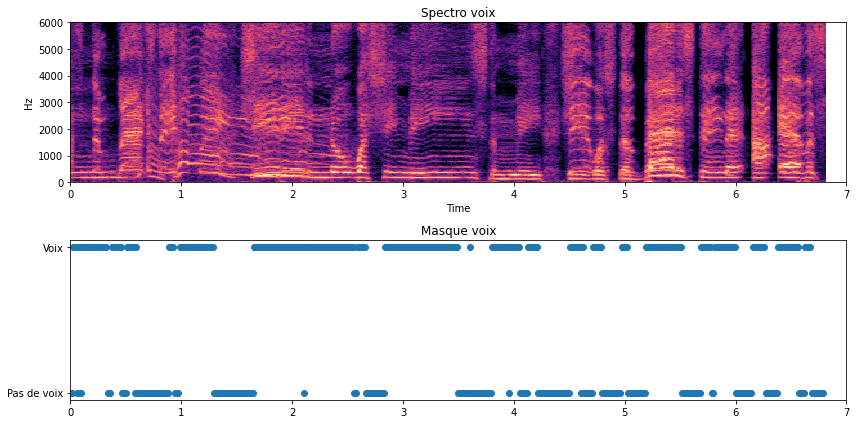

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


La musique  Angels In Amplifiers - I'm Alright  n'est pas dans la base train/test.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


Npiste (train/test) 55178 28763
Nhop= 587
Nfreq= 1025
Shape(train/test) (55178,) (28763,)


In [ ]:
# paramètres de la STFT
window_length=2048
hop_length=512

# coupure en db (par rapport au max)
db_cutoff = -15. 

# plot?
plot=True

# target 
y_train=np.array([])
y_test=np.array([])

for i in range(len(musdb)):
  voice=musdb[i]['sources']["vocals"]

  voice.stft_params = nussl.STFTParams(window_length=window_length, hop_length=hop_length)

  stft = voice.stft()

  # niveau puissance en db (en relatif par rapport max.)
  psd = 10*np.log10(voice.power_spectrogram_data/voice.power_spectrogram_data.max())

  # je moyenne sur canaux et on chope le max dans toute la gamme fréquentielle
  psdmax = np.max( (psd[:,:,0]+psd[:,:,1])/2., axis=0)

  # puis masque basé sur cette valeur
  tmask = np.where(psdmax  < db_cutoff, 0., 1.)
  
  # temps morceau et taille dt (nhop) de la stft
  t = voice.audio_data.shape[1]/voice.sample_rate 
  nhop = tmask.shape[0]
  dt = t/nhop
  t = dt*np.arange(nhop) 

  # nfreq est le nombre de fréquences de la stft
  nfreq0 = psd.shape[0]

# on trace... 0= pas de voix
  if (plot) and i==54 :
    AudioDisplay(Audio(data=musdb[i]['sources']["vocals"].audio_data, rate=musdb[i]['sources']["vocals"].sample_rate)) 
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    nussl.core.utils.visualize_spectrogram(voice,y_axis='linear')
    plt.title('Spectro voix')
    plt.ylim(0,6000)
    plt.xlim(0,7)
    plt.subplot(212)
    plt.title('Masque voix')
    plt.scatter(t,y=tmask)
    plt.xlim(0,7)
    plt.yticks([0,1],['Pas de voix', 'Voix'])
    plt.tight_layout()
    plt.show()

  # Prendre en compte le dossier train/test qu'on nous a fourni
  # on stocke à la suite toutes ces valeurs
  if mus[i].name in df["Track name"].to_list():
    if df[df["Track name"]==mus[i].name].iloc[0,df.columns.get_loc('Dataset')]=="train":
      y_train=np.append(y_train,tmask)  
    elif df[df["Track name"]==mus[i].name].iloc[0,df.columns.get_loc('Dataset')]=="test":
     y_test=np.append(y_test,tmask)
  else:
    print("La musique ",mus[i].name," n'est pas dans la base train/test.")


# ca y est
print('Npiste (train/test)',len(y_train),len(y_test))
print('Nhop=',nhop)
print('Nfreq=',nfreq0)
print('Shape(train/test)',y_train.shape,y_test.shape)